# Proof of Workout

## Requirements

In [64]:
%matplotlib inline

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

## Global Settings

In [4]:
WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
BGCOLOR = 'WHITE'
FIG_SETTINGS = dict(figsize=(20,6), dpi=144)

## Extract data from Apple Health
https://www.igeeksblog.com/how-to-import-and-export-health-app-data-on-iphone/

In [66]:
zipfile_path = 'export.zip' # add your pathname here

zf = zipfile.ZipFile(zipfile_path)
dataset = pd.read_xml(zf.open('apple_health_export/export.xml'))

## View available workout datasets

In [119]:
dataset['workoutActivityType'].value_counts()

HKWorkoutActivityTypeRunning                          256
HKWorkoutActivityTypeCycling                           59
HKWorkoutActivityTypeHighIntensityIntervalTraining     56
HKWorkoutActivityTypeTraditionalStrengthTraining       34
HKWorkoutActivityTypeDownhillSkiing                     5
Name: workoutActivityType, dtype: int64

In [120]:
dataset['type'].value_counts()

HKQuantityTypeIdentifierDistanceWalkingRunning            283533
HKQuantityTypeIdentifierStepCount                         275529
HKQuantityTypeIdentifierWalkingStepLength                  21687
HKQuantityTypeIdentifierWalkingSpeed                       21676
HKQuantityTypeIdentifierFlightsClimbed                     19845
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage     13852
HKQuantityTypeIdentifierHeadphoneAudioExposure              8176
HKQuantityTypeIdentifierWalkingAsymmetryPercentage          7126
HKCategoryTypeIdentifierSleepAnalysis                       1471
HKQuantityTypeIdentifierDietaryIron                          772
HKQuantityTypeIdentifierDietaryCalcium                       762
HKQuantityTypeIdentifierDietaryVitaminC                      757
HKQuantityTypeIdentifierDietaryProtein                       749
HKQuantityTypeIdentifierDietarySugar                         745
HKQuantityTypeIdentifierDietaryFiber                         740
HKQuantityTypeIdentifierD

In [121]:
# options for analyzing the data

timestamp_cols = ['creationDate', 'startDate', 'endDate']
numeric_cols = ['totalDistance', 'totalEnergyBurned', 'duration', 'value']

In [128]:
# example

dataset[dataset['type']=='HKQuantityTypeIdentifierDistanceWalkingRunning'][['creationDate', 'value']].tail()

,creationDate,value
559256,2022-01-02 09:52:33 -0500,0.0229348
559257,2022-01-02 10:23:15 -0500,0.0619072
559258,2022-01-02 10:45:55 -0500,0.0388543
559259,2022-01-02 11:36:26 -0500,0.0843201
559260,2022-01-02 11:44:12 -0500,0.0244012


## Visualization Script

In [146]:
DEFAULT_SETTINGS = {
    
    # global settings for a user
    "Year": 2021,                # should be a full year of data
    "TimeZone": "US/Eastern",    # time zone you spend most of your time in that year
    
    # plot specific settings
    "FilterColumn": "type",      # the categorical column to search in 
    "FilterSearch": "StepCount", # the keywords (regex OK) to search for in the column
    "AggColumn": "value",        # the numeric column to aggregate from     
    "AggThreshold": 0,           # a threshold value that ignores any values below it
    
    "ColorScaleParams": {
        "cmap": "YlGn",          # the colormap palette to use
        "vmin": 0,               # the value that corresponds to the lightest color
        "center": 10000,         # the value that corresponds to a medium-shade color
        "vmax": 20000            # the value that corresponds to the darkest color
    },
    "BackgroundColor": "White",  # background color of the image
    
}

In [147]:
def prep_data(raw_dataframe, user_settings, date_col="creationDate"):
    
    # filter for only the relevant activity records
    filt = raw_dataframe[user_settings["FilterColumn"]].str.contains(user_settings["FilterSearch"], regex=True)
    df = raw_dataframe[filt==True][[date_col, user_settings["AggColumn"]]].copy()
    
    # clean up the dates
    df["date"] = pd.to_datetime(df[date_col])
    df["date"] = df["date"].apply(lambda x: x.tz_convert(user_settings["TimeZone"]))
    df["year"] = df["date"].apply(lambda x: x.year)
    df["month"] = df["date"].apply(lambda x: x.month_name())
    df["weekday"] = df["date"].apply(lambda x: x.weekday)
    df["date"] = df["date"].apply(lambda x: x.date)
    df["weeknum"] = df["date"].apply(lambda x: x.isocalendar()[1] % 53)
    
    # filter by year
    df = df[df["year"]==user_settings["Year"]]
    
    # clean the numeric data
    df[user_settings["AggColumn"]] = pd.to_numeric(df[user_settings["AggColumn"]])
    
    return df

In [148]:
def plot_data(clean_dataframe, user_settings, title="Proof of Activity"):

    # set up the plot
    fig, ax = plt.subplots(facecolor=user_settings["BackgroundColor"], **FIG_SETTINGS)
    ax.set_facecolor(user_settings["BackgroundColor"])
    
    # make a pivot table
    pvt = pd.DataFrame(np.zeros(shape=(7,53)))
    pvt.update(clean_dataframe.pivot_table(
        index='weekday', 
        columns='weeknum', 
        values=user_settings["AggColumn"], 
        aggfunc='sum'
    ))
    
    # make the plot
    sns.heatmap(
        pvt, 
        mask=pvt.applymap(lambda x: x<=user_settings["AggThreshold"]),
        linecolor=user_settings["BackgroundColor"], 
        linewidths=2,
        square=True,
        cbar=False,
        ax=ax,
        **user_settings["ColorScaleParams"]
    )
        
    # format axes
    ax.tick_params(axis='both', which='both', length=0, labelrotation=0)
    
    xmax = pvt.columns.max() + 1.1
    ax.set_xlim(-.1,xmax)
    tick_mapper = {
        'Jan': 2.18, 'Feb': 6.58, 'Mar': 10.8,
        'Apr': 14.99, 'May': 19.37, 'Jun': 23.68,
        'Jul': 28.12, 'Aug': 32.72, 'Sep': 36.85,
        'Oct': 40.99, 'Nov': 45.65, 'Dec': 50.02
    }
    ax.set_xticks([v+1 for v in tick_mapper.values()])
    ax.set_xticklabels([k for k in tick_mapper.keys()], fontname="Lucida Grande", fontsize=12)
    ax.xaxis.tick_top()
    ax.set_xlabel('')

    ax.set_ylim(-0.1,7.1)
    ax.invert_yaxis()
    ax.set_yticklabels(WEEKDAYS, fontname="Lucida Grande", fontsize=12)
    ax.set_ylabel('')

    ax.set_title(f"{title}\n", loc='left', fontsize=14, weight='bold')
    
    return ax

In [149]:
def proof_of_workout(raw_dataframe, user_settings, date_col="creationDate", title="Proof of Workout"):
    df = prep_data(raw_dataframe, user_settings, date_col=date_col)
    chart = plot_data(df, user_settings, title=title)
    return chart

<AxesSubplot:title={'left':'Proof of Activity\n'}>

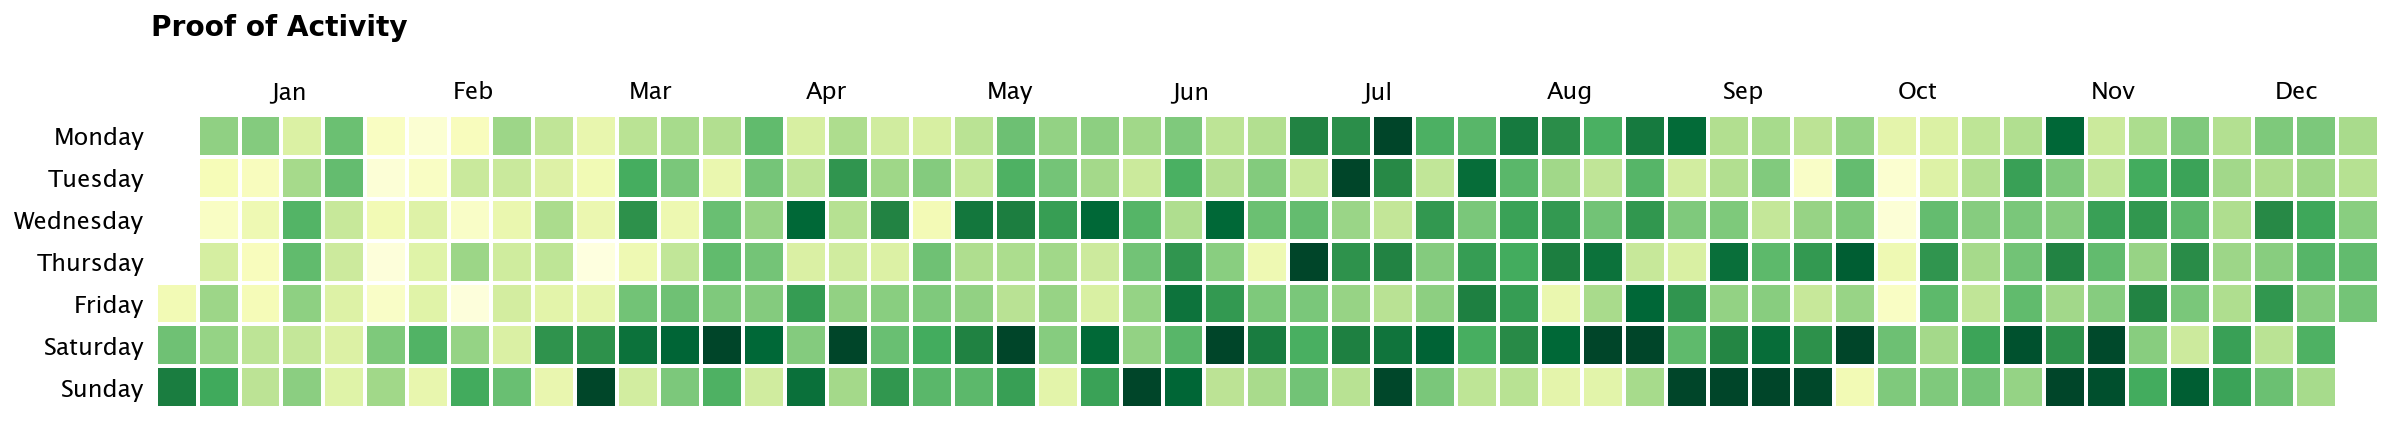

In [150]:
proof_of_workout(dataset, DEFAULT_SETTINGS, title="Proof of Activity")

## Examples

<AxesSubplot:title={'left':'2021: Proof of Workout (Minutes of Intense Exercise)\n'}>

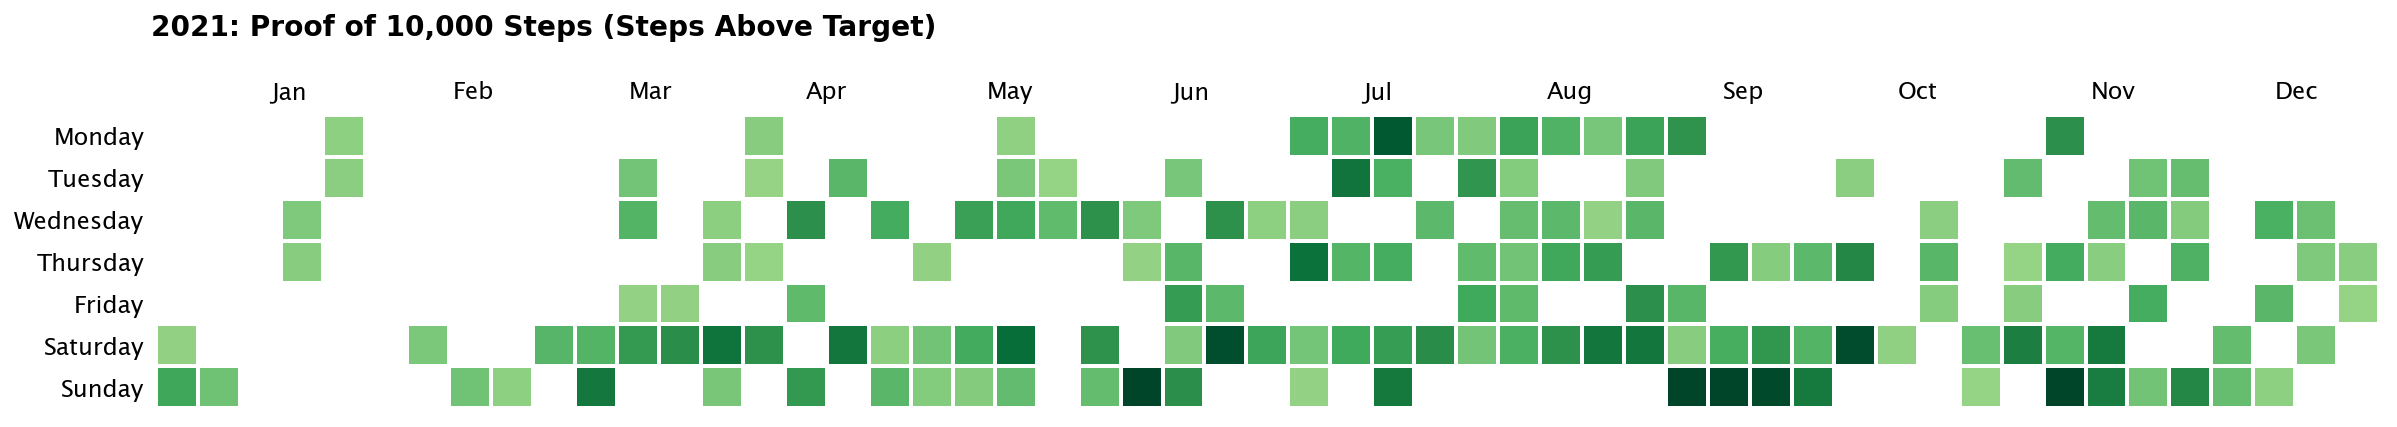

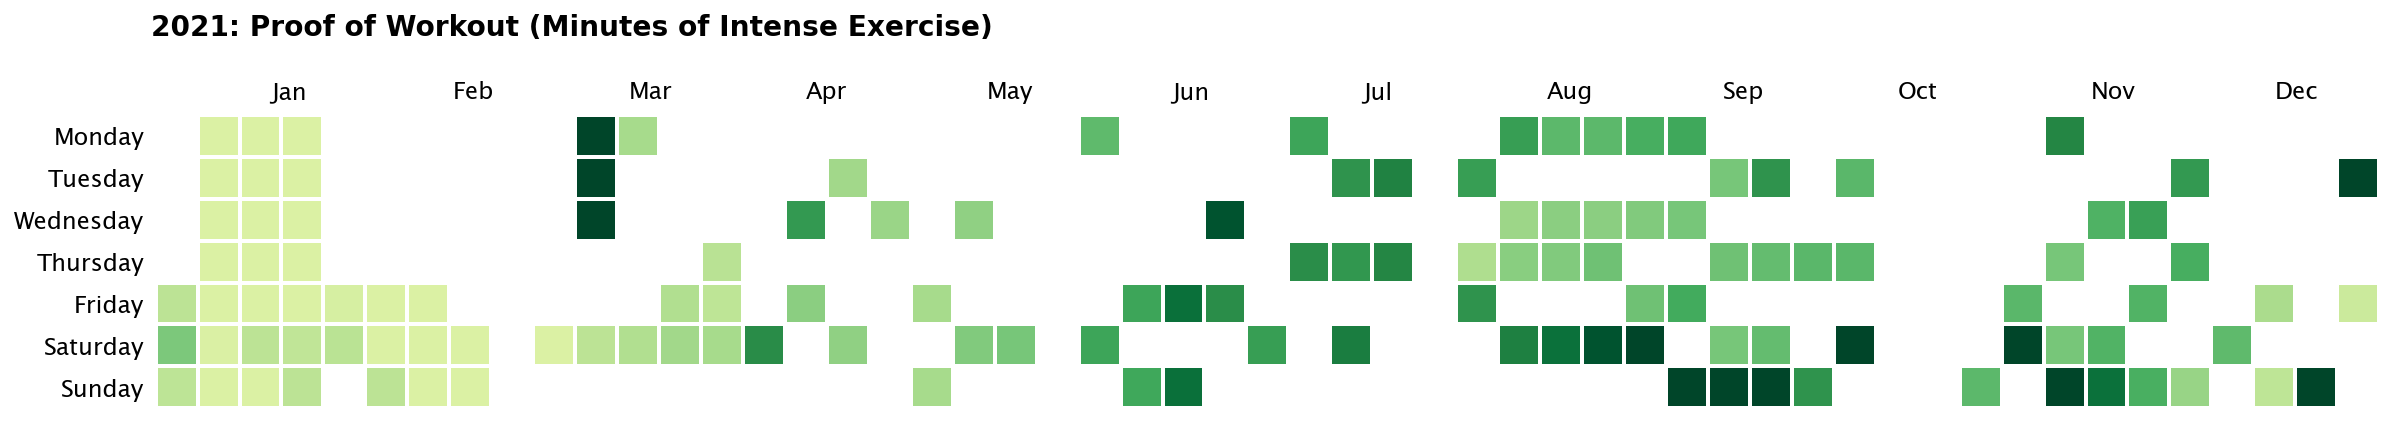

In [153]:
settings = {
    "Year": 2021,
    "TimeZone": "US/Eastern",    
    "FilterColumn": "type",
    "FilterSearch": "StepCount",
    "AggColumn": "value",
    "AggThreshold": 10000,
    "BackgroundColor": "White",
    "ColorScaleParams": {"cmap": "YlGn", "vmin": 0, "center": 12000, "vmax": 25000}
}
proof_of_workout(dataset, settings, title="2021: Proof of 10,000 Steps (Steps Above Target)")


settings = {
    "Year": 2021,
    "TimeZone": "US/Eastern",    
    "BackgroundColor": "White",    
    "FilterColumn": "workoutActivityType",
    "FilterSearch": "Workout",
    "AggColumn": "duration",
    "AggThreshold": 5,
    "ColorScaleParams": {"cmap": "YlGn", "vmin": 0, "center": 30, "vmax": 75}
}
proof_of_workout(dataset, settings, title="2021: Proof of Workout (Minutes of Intense Exercise)")

<AxesSubplot:title={'left':'2020: Proof of Workout (Minutes of Intense Exercise)\n'}>

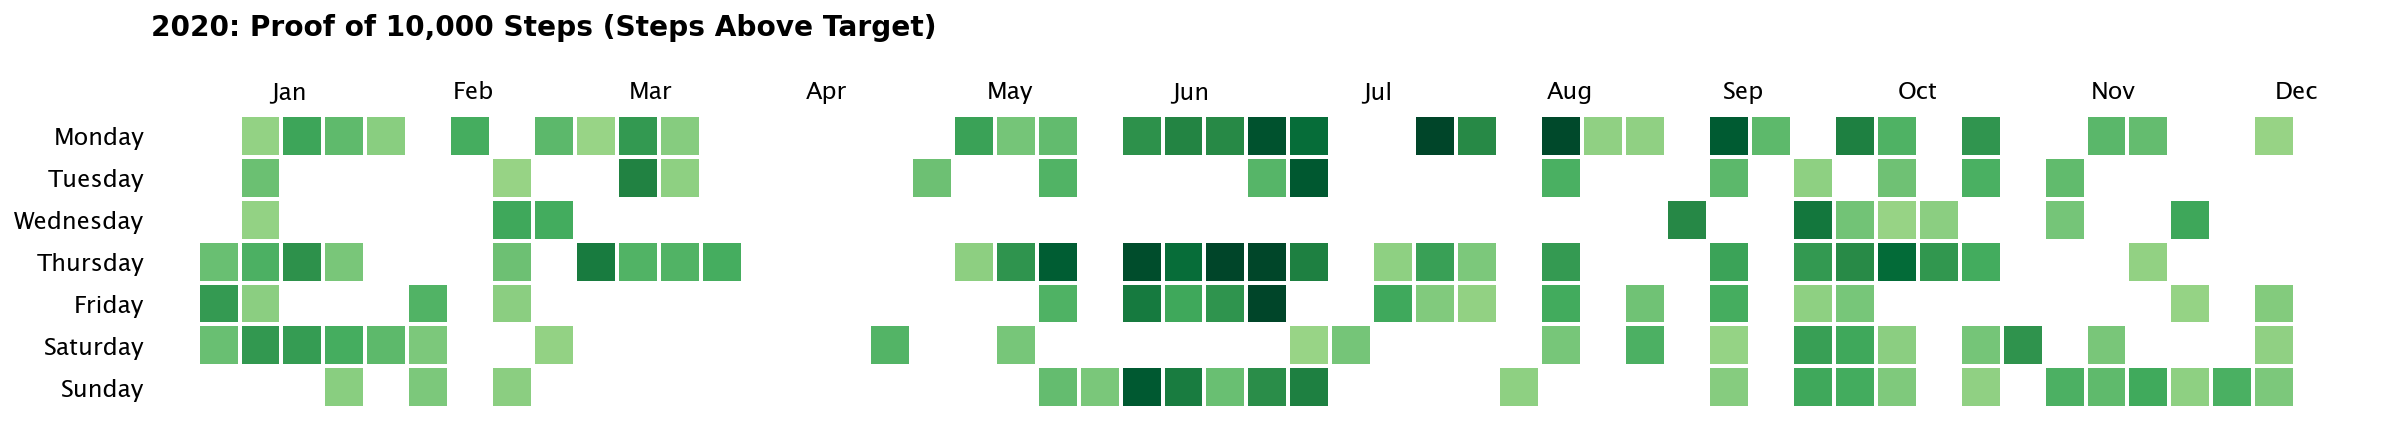

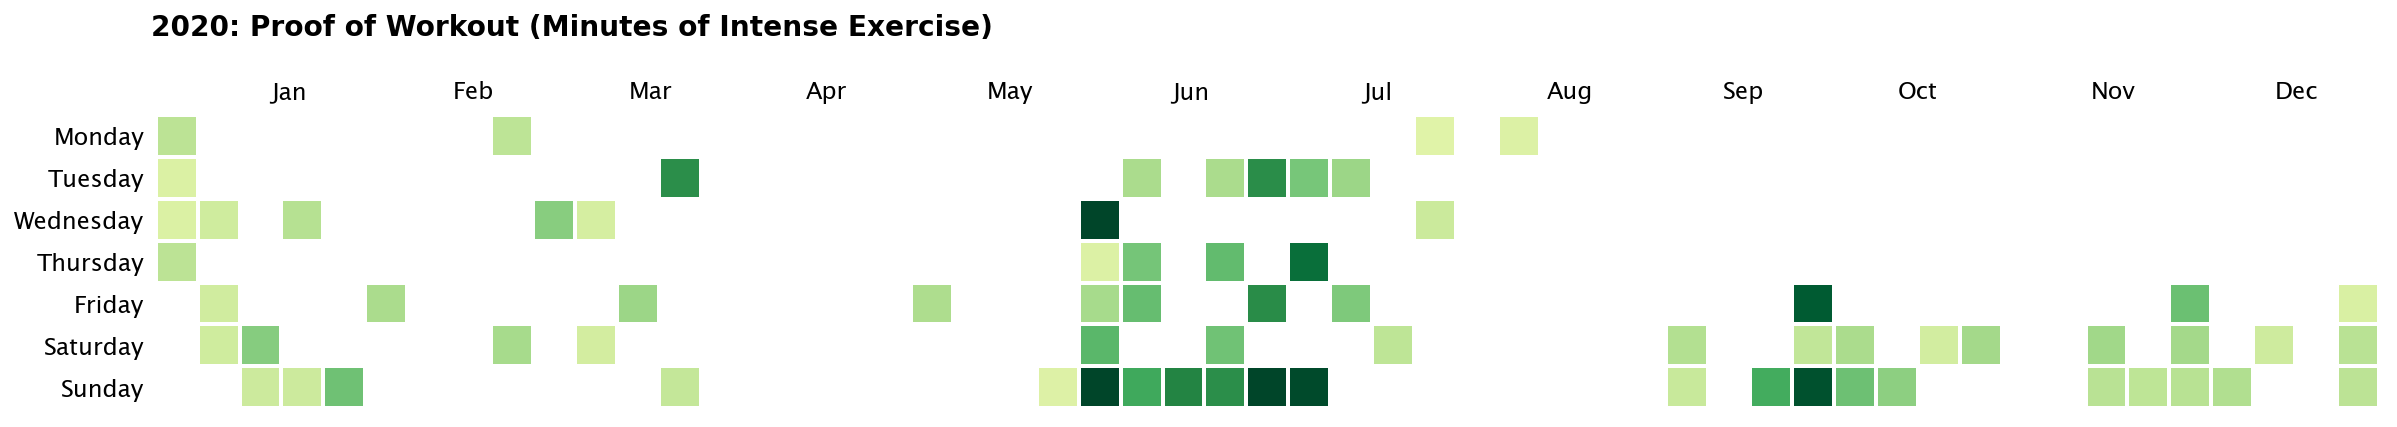

In [154]:
settings = {
    "Year": 2020,
    "TimeZone": "US/Eastern",    
    "FilterColumn": "type",
    "FilterSearch": "StepCount",
    "AggColumn": "value",
    "AggThreshold": 10000,
    "BackgroundColor": "White",
    "ColorScaleParams": {"cmap": "YlGn", "vmin": 0, "center": 12000, "vmax": 25000}
}
proof_of_workout(dataset, settings, title="2020: Proof of 10,000 Steps (Steps Above Target)")


settings = {
    "Year": 2020,
    "TimeZone": "US/Eastern",    
    "BackgroundColor": "White",    
    "FilterColumn": "workoutActivityType",
    "FilterSearch": "Workout",
    "AggColumn": "duration",
    "AggThreshold": 5,
    "ColorScaleParams": {"cmap": "YlGn", "vmin": 0, "center": 30, "vmax": 75}
}
proof_of_workout(dataset, settings, title="2020: Proof of Workout (Minutes of Intense Exercise)")

# Scrapbook

In [115]:
valid_cols = []
for c in dataset.columns:    
    records = dataset[c].dropna()
    if len(records) > 1:
        valid_cols.append(c)
        sample_data = list(records.value_counts().tail(3).index)
        print(f"{c} || {sample_data}\n")

value || ['0.00244584', '0.00110953', '0.00249224']

type || ['HKQuantityTypeIdentifierAppleWalkingSteadiness', 'HKQuantityTypeIdentifierHeight', 'HKDataTypeSleepDurationGoal']

sourceName || ['Citi Bike', 'Slopes', 'Fitplan']

sourceVersion || ['6178', '3', '25222']

unit || ['mmHg', 'ft', 'hr']

creationDate || ['2019-06-23 11:48:58 -0500', '2019-06-23 11:41:56 -0500', '2021-12-31 16:46:46 -0500']

startDate || ['2018-02-09 02:58:03 -0500', '2018-02-09 02:58:59 -0500', '2021-12-28 11:24:55 -0500']

endDate || ['2018-02-13 01:41:54 -0500', '2018-02-13 02:09:41 -0500', '2021-12-28 17:46:49 -0500']

device || ['<<HKDevice: 0x28361c0a0>, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone11,2, software:12.0>', '<<HKDevice: 0x2836795e0>, name:iPhone, manufacturer:Apple Inc., model:iPhone, hardware:iPhone9,1, software:13.3.1>', '<<HKDevice: 0x2836b94a0>, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone11,2, software:12.0>']

workoutActivityType || ['HKWorkoutActivi

In [116]:
timestamp_cols = ['creationDate', 'startDate', 'endDate']
numeric_cols = ['totalDistance', 'totalEnergyBurned', 'duration', 'value'] 
workout_cols = ['type', 'sourceName', 'device', 'workoutActivityType']

for c in workout_cols:
    for n in numeric_cols:
        df = dataset[[c,n]].dropna()
        if len(df):
            val = pd.to_numeric(df[n], errors='coerce').sum()
            if pd.to_numeric(df[n], errors='coerce').sum()>1:
                print(df.sort_values(by=n).tail(2))
                print()

                                         type  \
662950  HKCategoryTypeIdentifierSleepAnalysis   
664375  HKCategoryTypeIdentifierSleepAnalysis   

                                    value  
662950  HKCategoryValueSleepAnalysisInBed  
664375  HKCategoryValueSleepAnalysisInBed  

       sourceName  totalDistance
664702     Slopes      22.454957
664704     Slopes      24.090901

         sourceName  totalEnergyBurned
664784  Run Tracker        1693.880033
664797       Slopes        1769.640622

       sourceName    duration
664798     Slopes  151.064651
664797     Slopes  192.977692

           sourceName                              value
662950    Sleep Cycle  HKCategoryValueSleepAnalysisInBed
664375  Carl’s iPhone  HKCategoryValueSleepAnalysisInBed

                                                   device  \
663398  <<HKDevice: 0x2836143c0>, name:iPhone, manufac...   
663903  <<HKDevice: 0x283614500>, name:iPhone, manufac...   

                                    value  
663398  HK